# Reading input from S3 with Apache Spark on OpenShift

In this demonstration we will load both textual and [Apache Parquet](https://parquet.apache.org/) data from [AWS S3](https://aws.amazon.com/s3/). There are two key pieces of information to get from this demonstration,

0. First, loading of the S3 client libraries (hadoop-aws)
1. Second, configuring the client with S3 credentials.


### Important - load the S3 client libraries

This uses some Jupyter line magic to put **--packages** on the pyspark command line for the kernel.

In [1]:
%set_env PYSPARK_SUBMIT_ARGS=--packages=org.apache.hadoop:hadoop-aws:2.7.3 pyspark-shell

env: PYSPARK_SUBMIT_ARGS=--packages=org.apache.hadoop:hadoop-aws:2.7.3 pyspark-shell


Setup your SparkSession as you normally would.

In [2]:
import pyspark

from pyspark.context import SparkContext
from pyspark.sql import SparkSession, SQLContext

#spark = SparkSession.builder.master("local[*]").getOrCreate()
spark = SparkSession.builder.master("spark://cluster-stjhqo:7077").getOrCreate()

### Important - configure the S3 client with your credentials
Don't store your credentials in code, use [Secrets](https://kubernetes.io/docs/user-guide/secrets/). Do use [AWS IAM](https://aws.amazon.com/iam/) and credentials with only the capabilities needed for your application.

In [3]:
hadoopConf=spark.sparkContext._jsc.hadoopConfiguration()
hadoopConf.set("fs.s3a.access.key", "YOUR ACCESS KEY ID")
hadoopConf.set("fs.s3a.secret.key", "YOUR SECRET KEY")

This is a simple test to see what workers are available in your cluster.

In [4]:
import socket
spark.range(100, numPartitions=100).rdd.map(lambda x: socket.gethostname()).distinct().collect()

['cluster-stjhqo-w-1-ompxg',
 'cluster-stjhqo-w-1-ql0g6',
 'cluster-stjhqo-w-1-l8883']

## Read a simple text file from S3

In [5]:
df0 = spark.read.text("s3a://radanalytics/jabberwocky.txt")

In [6]:
df0.schema.jsonValue()

{'fields': [{'metadata': {},
   'name': 'value',
   'nullable': True,
   'type': 'string'}],
 'type': 'struct'}

In [7]:
df0.show(3)

+--------------------+
|               value|
+--------------------+
|'Twas brillig, an...|
|Did gyre and gimb...|
|All mimsy were th...|
+--------------------+
only showing top 3 rows



In [8]:
from operator import add
df0.rdd.flatMap(lambda x: list(x[0])).map(lambda x: (x, 1)).reduceByKey(add).sortBy(lambda x: x[1], ascending=False).take(5)

[(u' ', 139), (u'e', 80), (u't', 59), (u'h', 57), (u'a', 52)]

## Read a parquet file from S3

In [9]:
df1 = spark.read.parquet("s3a://radanalytics/wikieod.parquet")

In [10]:
df1.schema.jsonValue()

{'fields': [{'metadata': {},
   'name': 'ticker',
   'nullable': True,
   'type': 'string'},
  {'metadata': {}, 'name': 'date', 'nullable': True, 'type': 'string'},
  {'metadata': {}, 'name': 'close', 'nullable': True, 'type': 'double'}],
 'type': 'struct'}

In [11]:
df1.count()

14437399

In [12]:
rht = df1.filter(df1.ticker == "RHT")

rht.show(10)
rht.count()

+------+----------+-----+
|ticker|      date|close|
+------+----------+-----+
|   RHT|1999-08-26|78.94|
|   RHT|1999-11-26|213.5|
|   RHT|2000-02-29|60.69|
|   RHT|2000-05-31|16.06|
|   RHT|2000-08-30|25.44|
|   RHT|2000-11-30| 6.25|
|   RHT|2001-03-06| 6.75|
|   RHT|2001-06-06| 5.55|
|   RHT|2001-09-06| 3.18|
|   RHT|2001-12-12|  8.5|
+------+----------+-----+
only showing top 10 rows



4325

In [13]:
from pyspark.sql.functions import min, max
rht.agg(max("close"),min("close")).show()

+----------+----------+
|max(close)|min(close)|
+----------+----------+
|    286.25|      3.02|
+----------+----------+



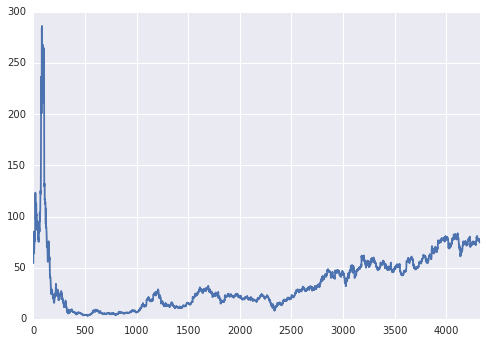

In [14]:
%matplotlib inline
import seaborn as sns
_ = sns.tsplot(rht.sort(rht.date).toPandas().close)